In [1]:
%%capture
# Load the quadrotor simulator from a previous notebook
%run quadsim.ipynb

In [2]:
from IPython.core.display import HTML
HTML('<style>.impl-inner{background-color:#e4ffe6} .impl-outer{background-color:#e4ebff} .text_cell_render p { text-align: justify; text-justify: inter-word;}</style>')

# Sliding Mode Control


This notebook discusses and implements a sliding mode controller for the attitude control of a quadrotor. The discussion follows the 2016 work of Shaik and Whidborne from Cranfield, UK [1]. An error representation is used to enable tracking of trajectories in $\phi$, $\theta$, $\psi$, or $r_z$. Note that there is currently no outer loop control of the quadrotor.

Compared to the [SMC implementation based on L'Afflitto](sliding_mode_control.ipynb), this implementation is more introductory and follows the motivating example of [2, Ch 14.1.1].

## Quadrotor Model

The derivation of the standard quadrotor model used herein can be found in the [Quadrotor Model](quadrotor_model.ipynb) notebook. We use the form with inertial translational kinematics and dynamics, and it is restated below, with the state defined as
\begin{align}
x &\triangleq
\begin{bmatrix} r_x & r_y & r_z & \dot{r}_x & \dot{r}_y & \dot{r}_z & \phi & \theta & \psi & p & q & r \end{bmatrix}^\top,
\end{align}

which evolves with the following simplified dynamics (i.e., $\Gamma\approx I_{3\times 3}$ so that we can easily perform control)

\begin{equation}
x =
\begin{bmatrix} \dot{r}_x \\ \dot{r}_y \\ \dot{r}_z \\ \ddot{r}_x \\ \ddot{r}_y \\ \ddot{r}_z \\ \dot{\phi} \\ \dot{\theta} \\ \dot{\psi} \\ \dot{p} \\ \dot{q} \\ \dot{r} \end{bmatrix} =
\begin{bmatrix}
\dot{r}_x \\ \dot{r}_y \\ \dot{r}_z \\
-\frac{u_1}{m}(\cos\phi\sin\theta\cos\psi+\sin\phi\sin\psi) \\
-\frac{u_1}{m}(\cos\phi\sin\theta\sin\psi-\sin\phi\sin\psi) \\
g-\frac{u_1}{m}(\cos\phi\cos\theta) \\
p \\ q \\ r \\
\frac{J_y - J_z}{J_x} qr + \frac{1}{J_x} u_2 \\
\frac{J_z - J_x}{J_y} pr + \frac{1}{J_y} u_3 \\
\frac{J_x - J_y}{J_z} pq + \frac{1}{J_z} u_4
\end{bmatrix}.
\end{equation}

<!--
\begin{equation}
x =
\begin{bmatrix} \dot{r_x} \\ \dot{r_y} \\ \dot{r_z} \\ \ddot{r_x} \\ \ddot{r_y} \\ \ddot{r_z} \\ \dot{\phi} \\ \dot{\theta} \\ \dot{\psi} \\ \dot{p} \\ \dot{q} \\ \dot{r} \end{bmatrix} =
\begin{bmatrix}
x_4 \\ x_5 \\ x_6 \\
-\frac{u_1}{m}(\cos x_7\sin x_8\cos x_9+\sin x_7\sin x_9) \\
-\frac{u_1}{m}(\cos x_7\sin x_8\sin x_9-\sin x_7\sin x_9) \\
g-\frac{u_1}{m}(\cos x_7\cos x_8) \\
x_{10} \\ x_{11} \\ x_{12} \\
\frac{J_y - J_z}{J_x} x_{11} x_{12} + \frac{1}{J_x} u_2 \\
\frac{J_z - J_x}{J_y} x_{10} x_{12} + \frac{1}{J_y} u_3 \\
\frac{J_x - J_y}{J_z} x_{10} x_{11} + \frac{1}{J_z} u_4
\end{bmatrix}.
\end{equation}
-->

The input to this system is defined as
\begin{align}
u &\triangleq
\begin{bmatrix} T & \tau_\phi & \tau_\theta & \tau_\psi \end{bmatrix}^\top.
\end{align}

## Shaik's Implementation

In Shaik [1], four scalar sliding surfaces are defined as
$$
\begin{equation}
s_\alpha = \dot{e}_\alpha + \lambda_\alpha e_\alpha = 0,
\end{equation}
$$
where $\lambda_\alpha$ is a tuning gain and the relevant tracking error is defined as $e_\alpha = \alpha^d - \alpha$. The variable $\alpha$ is used as a placeholder for one of the relevant states: $\phi$, $\theta$, $\psi$, or $r_z$. The time derivative of the sliding manifold is
$$
\begin{equation}
\dot{s}_\alpha = -f -u + \ddot\alpha^d + \lambda_\alpha \dot{e}_\alpha.
\end{equation}
$$

The objective of the sliding mode controller is to choose an input $u$ for each choice of $\alpha$ s.t. system trajectories are driven to the sliding manifold ($s_\alpha=0$) in finite time, which is then asymptotically driven to zero. This is done by choosing the following control inputs, with $k_\alpha$ a scalar tuning gain:
$$
\begin{align}
u_1 &= - \frac{m}{\cos\phi\cos\theta}\left[ -g +\ddot{r}_z^d +\lambda_{r_z}\dot{e}_{r_z} + k_{r_z}\text{sgn}(s_{r_z})\right] \label{eq:shaik-u1} \\
u_2 &= J_x\left[ -\frac{J_y - J_z}{J_x} qr + \ddot\phi^d + \lambda_\phi \dot{e}_\phi + k_\phi \text{sgn}(s_\phi)\right] \\
u_3 &= J_y\left[ -\frac{J_z - J_x}{J_y} pr + \ddot\theta^d + \lambda_\theta \dot{e}_\theta + k_\theta \text{sgn}(s_\theta)\right] \\
u_4 &= J_z\left[ -\frac{J_x - J_y}{J_z} pq + \ddot\psi^d + \lambda_\psi \dot{e}_\psi + k_\psi \text{sgn}(s_\psi)\right]. \label{eq:shaik-u4}
\end{align}
$$

## Discussion of Shaik's Implementation

Note that in [1], a right-handed coordinate frame with $z$ up is used (as opposed to NED, which is used in this series of notebooks). Therefore, the body coordinate frame is a front-left-up (FLU). As a result, the sign of equation \eqref{eq:shaik-u1} is different than $U_4$ in the paper. Also notice that in this notebook we have used $u_1$ for the force equation corresponding to thrust.

The sign issue can be more easily seen if fill in some of the gaps in Shaik's paper. Consider equation (15) of Shaik, which is a common sliding surface definition. Note how the sliding surface is $s_\alpha = \dot{e}_\alpha - \phi(e_\alpha) = 0$, where $\phi(e_\alpha) = -\lambda_\alpha e_\alpha$ is a linear control law, resulting in $s_\alpha = \dot{e}_\alpha + \lambda_\alpha e_\alpha$.

Now that we have identified a sliding surface such that $e_\alpha \to 0$ when the system is steered to the surface, we need to choose an input $u_\alpha$ to drive all system trajectories to the surface $s_\alpha=0$. Choosing the Lyapunov function $V = \frac{1}{2}s_\alpha^2$, we desire that $\dot{V} = s_\alpha\dot{s}_\alpha < 0$. The time-derivative of $s_\alpha$ is
\begin{align}
\dot{s}_\alpha &= \ddot{e}_\alpha + \lambda_\alpha \dot{e}_\alpha \\
&= \ddot{\alpha}^d - \ddot{\alpha} + \lambda_\alpha \dot{e}_\alpha \\
&= \ddot{\alpha}^d - f(\alpha, u_\alpha) + \lambda_\alpha \dot{e}_\alpha \\
&= \ddot{\alpha}^d - f_1(\alpha) - bu_\alpha + \lambda_\alpha \dot{e}_\alpha.  \quad \text{*} \label{eq:sdot}
\end{align}

Note that in step $\text{*}$ we have assumed that the dynamics $f(\alpha, u_\alpha)$ are linear in the control input $u_\alpha$. That is, $\;f(\alpha, u_\alpha) = f_1(\alpha) + bu_\alpha$. Here, we have a choice (see [2, p565]) on whether we design a control $u_\alpha$ that has only a switching component, or we may also add a continuous component that cancels any of the known quantities in \eqref{eq:sdot}. Given that we know the dynamics (albeit, with some uncertainty), we design a control that has the switching component $\beta(e_\alpha) sgn(s_\alpha)$ and a continuous component to cancel out what we know. Therefore, our designed control input is
$$
\begin{equation}
u_\alpha = \frac{1}{b}\left[\underbrace{\ddot{\alpha}^d - f_1(\alpha) + \lambda_\alpha \dot{e}_\alpha}_{continuous} + \underbrace{k_\alpha \text{sgn}(s_\alpha)}_{switching}\right].
\end{equation}
$$

The switching component is a fundamental aspect of sliding mode control. Its purpose is ensure that $\dot{V} = s_\alpha\dot{s}_\alpha < -\eta \left|s_\alpha\right| < 0$ for some value of $\eta$. See Khalil p552 [2] for more information.

In [3]:
def sat(v):
    return v if np.abs(v) <= 1 else np.sign(v)

class ShaikSMC(Controller):
    """Sliding Mode Controller
    """
    def __init__(self):
        self.name = "Shaik SMC"
        
        # dirty derivative filters
        self.dZdt = DirtyDerivative(order=1, tau=0.05)
        self.dZdt2 = DirtyDerivative(order=2, tau=0.05)
        self.dphdt = DirtyDerivative(order=1, tau=0.05)
        self.dphdt2 = DirtyDerivative(order=2, tau=0.05)
        self.dthdt = DirtyDerivative(order=1, tau=0.05)
        self.dthdt2 = DirtyDerivative(order=2, tau=0.05)
        self.dpsdt = DirtyDerivative(order=1, tau=0.05)
        self.dpsdt2 = DirtyDerivative(order=2, tau=0.05)
        
        # estimates of the physical properties of the quadrotor
        self.g = 9.8
        self.mass = 4
#         Jxx = 0.060224; Jyy = 0.122198; Jzz = 0.132166
        Jxx = 0.1; Jyy = 0.1; Jzz = 0.1
        self.I = np.array([[Jxx,0,0],
                           [0,Jyy,0],
                           [0,0,Jzz]])
        
    def inner(self, commanded, state, Ts):
        # Transform the system into the form of HK (14.4) and (14.5)
        eta = np.array([state.flatten()[[2, 6, 7, 8]]]).T # r_z, ph, th, ps
        xi = np.array([state.flatten()[[5, 9, 10, 11]]]).T # \dot{r_z}, p, q, r
        
        ph = eta.flatten()[1]
        th = eta.flatten()[2]
        ps = eta.flatten()[3]
        
        Jx = self.I[0,0]
        Jy = self.I[1,1]
        Jz = self.I[2,2]
        
        #
        # r_z
        #
        
        # Desired
        des_Z = commanded[0]
        des_Zdot = self.dZdt.update(des_Z, Ts)
        des_Zddot = self.dZdt2.update(des_Zdot, Ts)
        
        # Gains
        lam_Z = 3
        kZ = 6
        
        # error
        e_Z = des_Z - eta[0]
        e_Zdot = des_Zdot - xi[0]
        
        
        sZ = e_Zdot + lam_Z*e_Z
#         u1 = -self.mass/(np.cos(ph)*np.cos(th))*(-self.g + des_Zddot + lam_Z*e_Zdot + kZ*np.sign(sZ))
        u1 = -self.mass/(np.cos(ph)*np.cos(th))*(-self.g + des_Zddot + lam_Z*e_Zdot + kZ*sat(sZ/0.5))
    
        # sign difference -- it seems that because of the way the tracking error was defined, it
        # it doesn't look quite the same as in Khalil [2] (Should be all positive -- see other nb).
        u1 = self.mass/(np.cos(ph)*np.cos(th))*(self.g + des_Zddot - lam_Z*e_Zdot) + kZ*sat(-sZ/0.5)
        
        #
        # \phi
        #
        
        # Desired
        des_ph = commanded[1]
        des_phdot = self.dphdt.update(des_ph, Ts)
        des_phddot = self.dphdt2.update(des_phdot, Ts)

        # Gains
        lam_ph = 3
        kph = 1
        
        # error
        e_ph = des_ph - eta[1]
        e_phdot = des_phdot - xi[1]
        
        sph = e_phdot + lam_ph*e_ph       
        u2 = Jx*(-(Jy-Jz)/Jx*xi[2]*xi[3] + des_phddot + lam_ph*e_phdot + kph*np.sign(sph))
        
        #
        # \theta
        #
        
        # Desired
        des_th = commanded[2]
        des_thdot = self.dthdt.update(des_th, Ts)
        des_thddot = self.dthdt2.update(des_thdot, Ts)

        # Gains
        lam_th = 3
        kth = 1
        
        # error
        e_th = des_th - eta[2]
        e_thdot = des_thdot - xi[2]
        
        sth = e_thdot + lam_th*e_th       
        u3 = Jy*(-(Jz-Jx)/Jy*xi[1]*xi[3] + des_thddot + lam_th*e_thdot + kth*np.sign(sth))
        
        #
        # \psi
        #
        
        # Desired
        des_ps = commanded[3]
        des_psdot = self.dpsdt.update(des_ps, Ts)
        des_psddot = self.dpsdt2.update(des_psdot, Ts)

        # Gains
        lam_ps = 3
        kps = 1
        
        # error
        e_ps = des_ps - eta[3]
        e_psdot = des_psdot - xi[3]
        
        sps = e_psdot + lam_ps*e_ps       
        u4 = Jz*((Jx-Jy)/Jz*xi[1]*xi[2] + des_psddot + lam_ps*e_psdot + kps*np.sign(sps))
              
        u = np.hstack(np.array([u1,u2,u3,u4]))
        
        return u
    
    def outer(self):
        pass
    
    def update(self, commanded, state, pkt, Ts):
        
        #
        # Outer Loop
        #
        
        #
        # Inner Loop
        #
        
        cmd = commanded[[2,6,7,8]]
        
        u = self.inner(cmd, state, Ts)
        
        # actuator commands
        return u, commanded

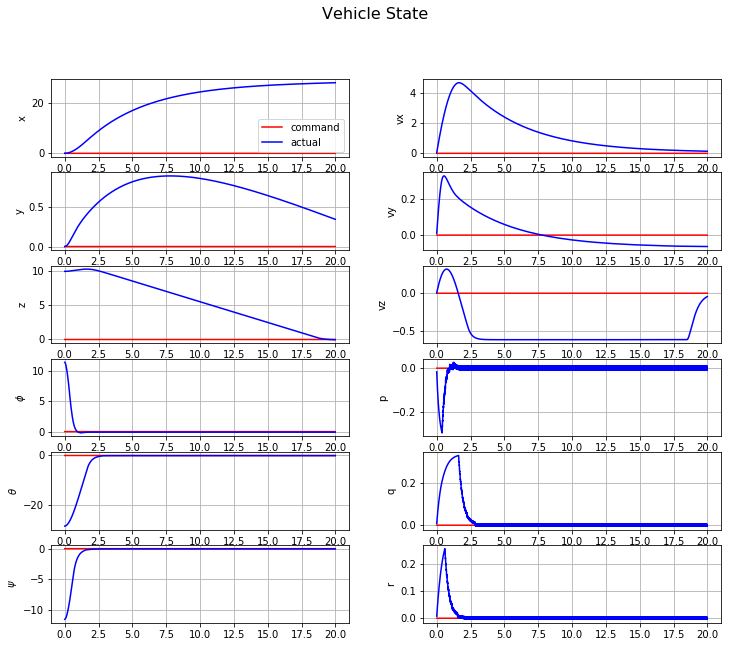

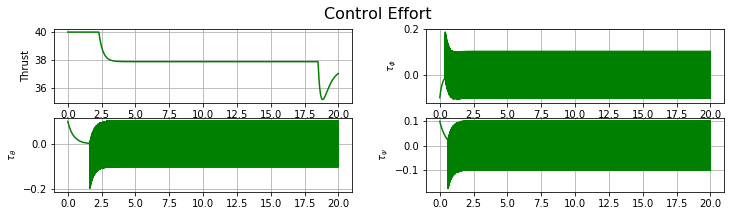

Quadrotor state after 2000 iters:
	r:     [[ 27.950  0.343 -0.030]].T
	Phi:   [[-0.002 -0.001 -0.001]].T
	v:     [[ 0.138 -0.063 -0.044]].T
	omega: [[ 0.009 -0.004 -0.004]].T



In [4]:
# Instantiate a quadrotor model with the given initial conditions
quad = Quadrotor(r=np.array([[0],[0],[10]]),
                 v=np.array([[0],[0],[0]]),
               Phi=np.array([[0.2],[-0.5],[-0.2]]))

# Instantiate the SMC controller
ctrl = ShaikSMC()

# Setup a setpoint commander
cmdr = Commander(default=True)

# Run the simulation
sim = Simulator(quad, ctrl, cmdr=cmdr)
sim.run(20, Ts=0.01)
sim.plot()

print(sim.quad)

## References

[1] M. K. Shaik and J. F. Whidborne, “Robust Sliding Mode Control of a Quadrotor,” 11th Int. Conf. Control, pp. 1–5, 2016.

[2] H. K. Khalil, Nonlinear Systems. Princeton, NJ: Prentice Hall, 2002.